In [1]:
import os
os.chdir("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import wigpy

from src.tourism.ts_utils import *
from src.text.epu import *
from src.text.utils import *
from statsmodels.tsa.api import VAR

In [2]:
nlp = spacy.load("en_core_web_sm")
folderpath = os.getcwd() + "/data/text/solomon_islands/"
target_dir = os.getcwd() + "/outputs/text/solomon_islands/"

In [3]:
files_list = [
    folderpath + file for file in os.listdir(folderpath)
    if "news" in file and "ner" not in file]

In [4]:
epu_df = pd.DataFrame()
for file, nn in zip(files_list, ["sibc", "ss", "st", "tis", "abc", "rnz"]):
    epu = EPU(filepath=file)
    epu.get_epu_category(subset_condition="date >= '2015-01-01'")
    temp = epu.get_epu_stats(cutoff="2020-01-01").fillna(0)
    temp.columns = [
        str(nn) + "_" + col if col not in ["date"] else col
        for col in temp.columns
    ]
    if epu_df.empty:
        epu_df = temp
    else:
        epu_df = epu_df.merge(temp, how="outer", on=["date"]).fillna(0)

In [5]:
news_count_cols = [
    col for col in epu_df.columns if col.endswith("news_count")
]
epu_df["news_count_total"] = epu_df[news_count_cols].sum(axis=1)
for col in news_count_cols:
    col_suffix = col.split("_")[-1]
    epu_df["weight_" +
              col_suffix] = epu_df[col] / epu_df["news_count_total"]
z_score_cols = [
    col for col in epu_df.columns if col.endswith("z_score")
]

In [6]:
for col in news_count_cols:
    col_suffix = col.split("_")[0]
    epu_df["weight_" +
              col_suffix] = epu_df[col] / epu_df["news_count_total"]

epu_df["z_score_weighted"] = 0
epu_df["z_score_unweighted"] = 0
for col in z_score_cols:
    col_suffix = col.split("_")[0]
    epu_df["z_score_weighted"] += epu_df["weight_" + col_suffix] * epu_df[col]

epu_df["z_score_unweighted"] = epu_df[z_score_cols].mean(axis=1)
scaling_factor_weighted = 100 / epu_df[epu_df.date < "2020-01-01"]["z_score_weighted"].mean()
scaling_factor_unweighted = 100 / epu_df[
    epu_df.date < "2020-01-01"]["z_score_unweighted"].mean()
epu_df["epu_score_weighted"] = epu_df[
    "z_score_weighted"] * scaling_factor_weighted
epu_df["epu_score_unweighted"] = epu_df[
    "z_score_unweighted"] * scaling_factor_unweighted

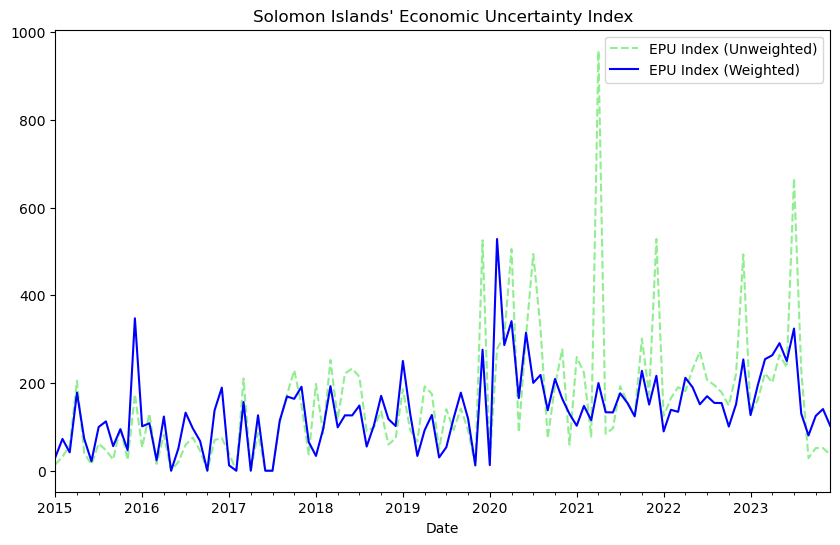

In [34]:

# epu_df.to_csv(os.getcwd() + "/outputs/text/solomon_islands/sib_epu.csv", encoding="utf-8")

fig, ax = plt.subplots(figsize=(10,6))
epu_df.plot(x="date", y="epu_score_unweighted", ax=ax, color="lightgreen", linestyle="--");
epu_df.plot(x="date", y="epu_score_weighted", ax=ax, color="blue");
plt.xlabel("Date")
plt.legend(["EPU Index (Unweighted)", "EPU Index (Weighted)"])
plt.title("Solomon Islands' Economic Uncertainty Index")
plt.show()
fig.savefig(target_dir+"sib_epu.jpg", dpi=400)

In [8]:
def check_entity_in_terms(row, terms):
    nlp = spacy.load('en_core_web_sm')
    if isinstance(row, str):
        doc = nlp(row)
        tokens = [token for token in doc]
        for token in tokens:
            lowered_token = str(token).lower()
            if lowered_token in terms and token.ent_type != 0:
                return True
            else:
                return False
    else:
        return False

## EPU -> Macroeconomic

In [9]:
si_cpi = [
    98.6, 99.0, 100.6, 100.7, 101.0, 100.6, 100.5, 100.1, 99.5, 99.6, 99.5,
    100.3, 102.0, 104.2, 103.9, 103.9, 103.0, 102.8, 103.0, 103.2, 104.1,
    104.0, 104.3, 104.4, 104.9, 104.1, 105.7, 104.8, 105.0, 105.1, 105.7,
    105.9, 106.3, 107.0, 107.5, 107.5, 114.2, 114.3, 114.1, 113.4, 112.2,
    107.6, 106.1, 105.3, 105.7, 105.6, 106.0, 104.5, 107.8, 111.6, 113.8,
    111.1, 110.8, 107.6, 106.9, 107.3, 108.0, 108.1, 108.2, 108.7, 109.8,
    110.4, 110.5, 112.7, 114.1, 114.3, 115.6, 117.6, 118.5, 119.8, 119.3,
    118.6, 120.3, 120.1, 120.0, 119.9, 119.6, 119.8, 120.9, 120.7, 120.9
]

si_infl_df = pd.DataFrame(pd.date_range("2017-01", "2023-09", freq="MS"),
                          columns=["date"])
si_infl_df["cpi"] = si_cpi
si_infl = si_infl_df.merge(epu_df[["date", "epu_score_weighted"]],
                           how="left",
                           on="date")
si_infl["inflation"] = (si_infl["cpi"].diff().shift(-1) / si_infl["cpi"]) * 100

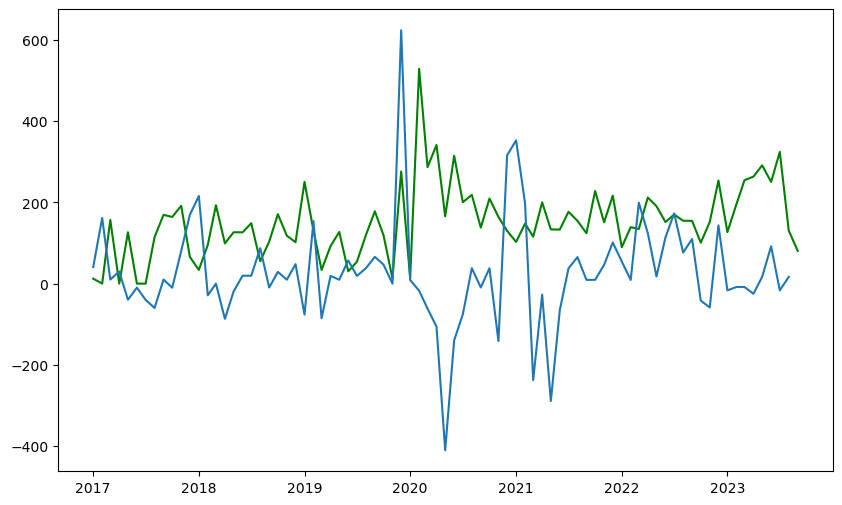

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(si_infl["date"].values, si_infl["epu_score_weighted"].values, label="epu_index", color="green")
plt.plot(si_infl["date"].values, si_infl["inflation"].values*100, label="inflation");

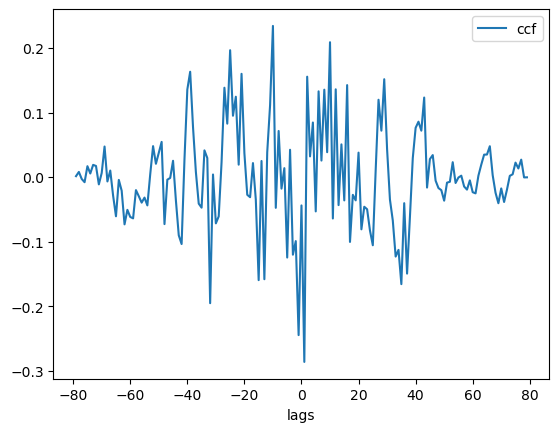

In [11]:
ccf_df = cross_correlation(si_infl["epu_score_weighted"][:-1], si_infl["inflation"][:-1])
ccf_df.plot(x="lags");

In [12]:
var_df = si_infl[["inflation", "epu_score_weighted"]][:-1]
print(adf_test(var_df["epu_score_weighted"]), "\n", adf_test(var_df["inflation"]))

Test Statistic                 -3.765045
p-value                         0.003286
# Lags Used                     1.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
Critical Value (5%)            -2.899375
Critical Value (10%)           -2.586955
dtype: float64 
 Test Statistic                -7.049004e+00
p-value                        5.589499e-10
# Lags Used                    0.000000e+00
Number of Observations Used    7.900000e+01
Critical Value (1%)           -3.515977e+00
Critical Value (5%)           -2.898886e+00
Critical Value (10%)          -2.586694e+00
dtype: float64


In [13]:
length = len(si_infl.iloc[:])
train = int(length * 0.95)
test = length - train


model = VAR(endog=var_df[:train+1])

eval_lst = []
for i in range(1, 13):
    result = model.fit(i)
    eval_metrics = {
        "lag": i,
        "AIC": result.aic,
        "BIC": result.bic,
        "FPE": result.fpe,
        "HQIC": result.hqic
    }
    eval_lst.append(eval_metrics)
    
eval_df = pd.DataFrame(eval_lst)
eval_df

,lag,AIC,BIC,FPE,HQIC
0,1,9.356876,9.540881,11579.112386,9.430413
1,2,9.195215,9.504213,9853.784467,9.318594
2,3,9.264076,9.699980,10564.037429,9.437964
3,4,9.289249,9.854020,10848.372239,9.514320
4,5,9.335235,10.030883,11385.061753,9.612175
5,6,9.444389,10.272976,12743.058161,9.773892
6,7,9.474440,10.438080,13199.483317,9.857210
7,8,9.525690,10.626555,13994.089533,9.962440
8,9,9.645347,10.885660,15928.666730,10.136797
9,10,9.630771,11.012818,15905.669202,10.177650


In [32]:
from statsmodels.tsa.vector_ar.vecm import VECM

best_mod = model.fit(1, trend="ct")
best_mod.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Jan, 2024
Time:                     16:37:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.49250
Nobs:                     76.0000    HQIC:                   9.34521
Log likelihood:          -559.071    FPE:                    10377.1
AIC:                      9.24716    Det(Omega_mle):         9365.34
--------------------------------------------------------------------
Results for equation inflation
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.563576         0.338980            1.663           0.096
trend                         0.008596         0.007179            1.197           0.231
L1.inflation            

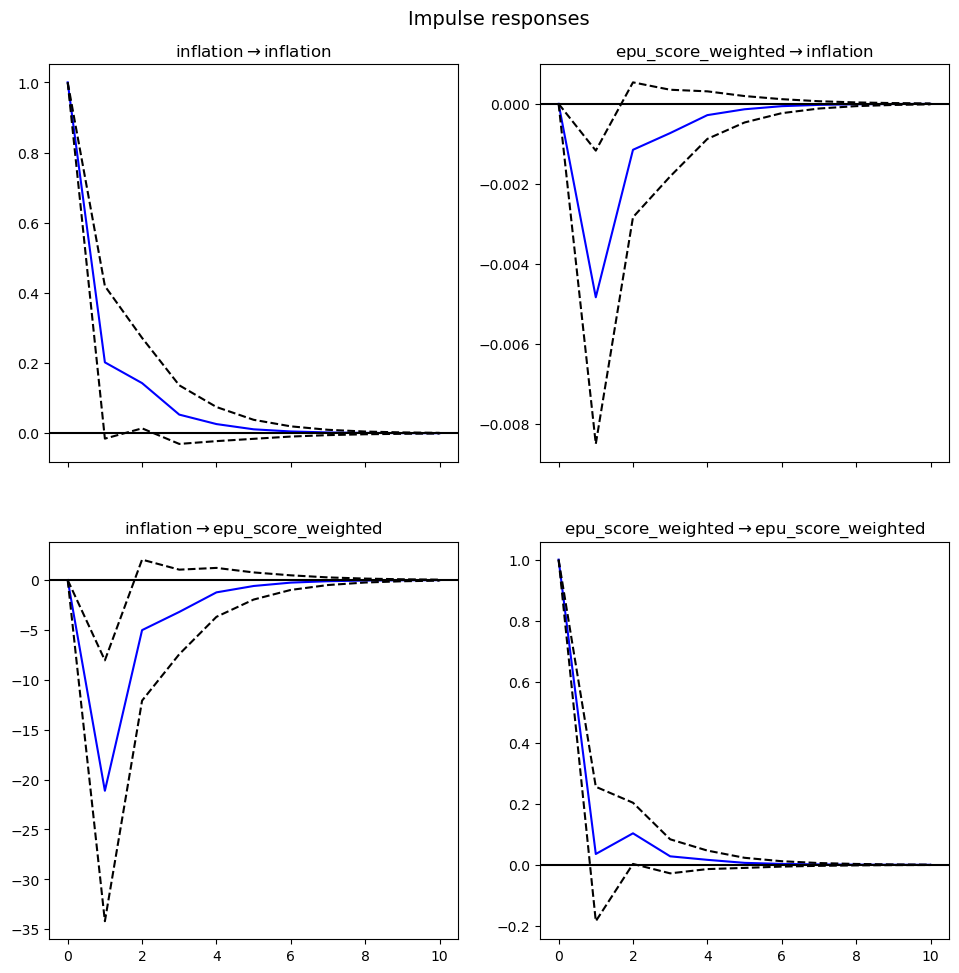

In [31]:
best_mod.irf().plot();

In [16]:
import statsmodels.formula.api as smf

ols_mod = smf.ols("inflation~epu_score_weighted", data=var_df)
maxlags = int(4 * (len(var_df)/100) ** (2/9)) + 1
ols_res = ols_mod.fit(cov_type='HAC',
                      cov_kwds={
                          "maxlags": maxlags,
                          "use_correction": True
                      })
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1500
Date:                Tue, 09 Jan 2024   Prob (F-statistic):              0.700
Time:                        16:30:21   Log-Likelihood:                -133.83
No. Observations:                  80   AIC:                             271.7
Df Residuals:                      78   BIC:                             276.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3613      0.233      1.550      0.121      -0.096       0.818
epu_score_weighted    -0.0006      0.002     -0.387      0.699      -0.004       0.003
==============================================================================
Omnibus:                       30.328   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.019
Skew:                           0.919   Prob(JB):                     9.76e-34
Kurtosis:                       9.498   Cond. No.                         347.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and with small sample correction
"""

In [17]:
ols_predict = ols_res.fittedvalues
# ols_forecast = ols_res.predict(si_infl["epu_change_1"])
# ols_all = pd.concat([ols_predict, ols_forecast], axis=0)

In [18]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(best_mod.resid)
out

array([1.98364548, 1.92856729])

In [19]:
var_forecast = best_mod.forecast(y=var_df.values[-test:], steps=test)
var_forecast_df = pd.DataFrame(var_forecast, index=var_df.index[-test:], columns=["var_inflation", "var_epu"])
var_df["date"] = si_infl["date"][var_df.index]


In [20]:
var_forecast_df["date"] = si_infl["date"][var_forecast_df.index]


In [21]:
fit_df = best_mod.fittedvalues.rename({"epu_index": "var_epu_index",
                                       "inflation": "var_inflation"}, axis=1)
fit_df = (pd.concat([fit_df, var_df.iloc[fit_df.index]], axis=1)
             .sort_values(by="date").reset_index(drop=True))

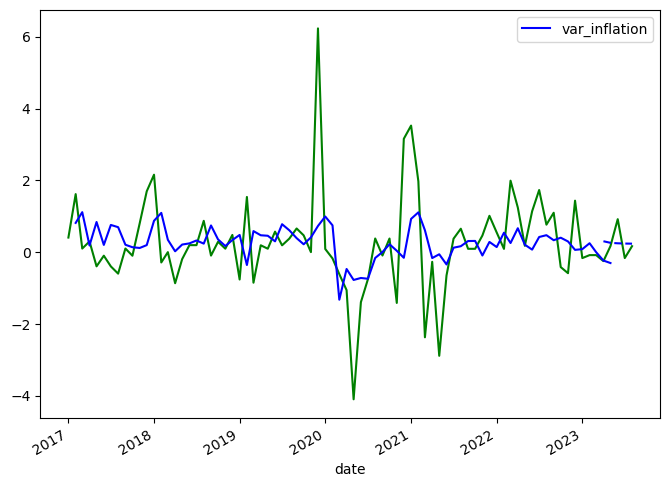

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(var_df["date"].values, var_df["inflation"].values, color="green")
fit_df.plot(x="date", y="var_inflation", ax=ax, color="blue")
ax.plot(var_forecast_df['date'].values,
        var_forecast_df["var_inflation"].values,
        label="var_predict_test", color="blue", linestyle="--")
ax.plot()
plt.show();